# Image Classification to detect sensitive data exposure

## Importing libraries and downloading the dataset

In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os
# Downloading the dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
git_folder = "/content/drive/MyDrive/kaggle/archive/processed_images"

training_folder = git_folder + "/train"
validation_folder = git_folder + "/test"
train_sensitive_dir = os.path.join(training_folder + "/cataract")
train_nonsensitive_dir = os.path.join(training_folder + "/normal")
validation_sensitive_dir = os.path.join(validation_folder + "/cataract")
validation_nonsensitive_dir = os.path.join(validation_folder + "/normal")

# Image Dataset size
print('Total training sensitive images:', len(os.listdir(train_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(train_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 245
Total training nonsensitive images: 246
Total validation sensitive images: 61
Total validation nonsensitive images: 60


## Sample Data

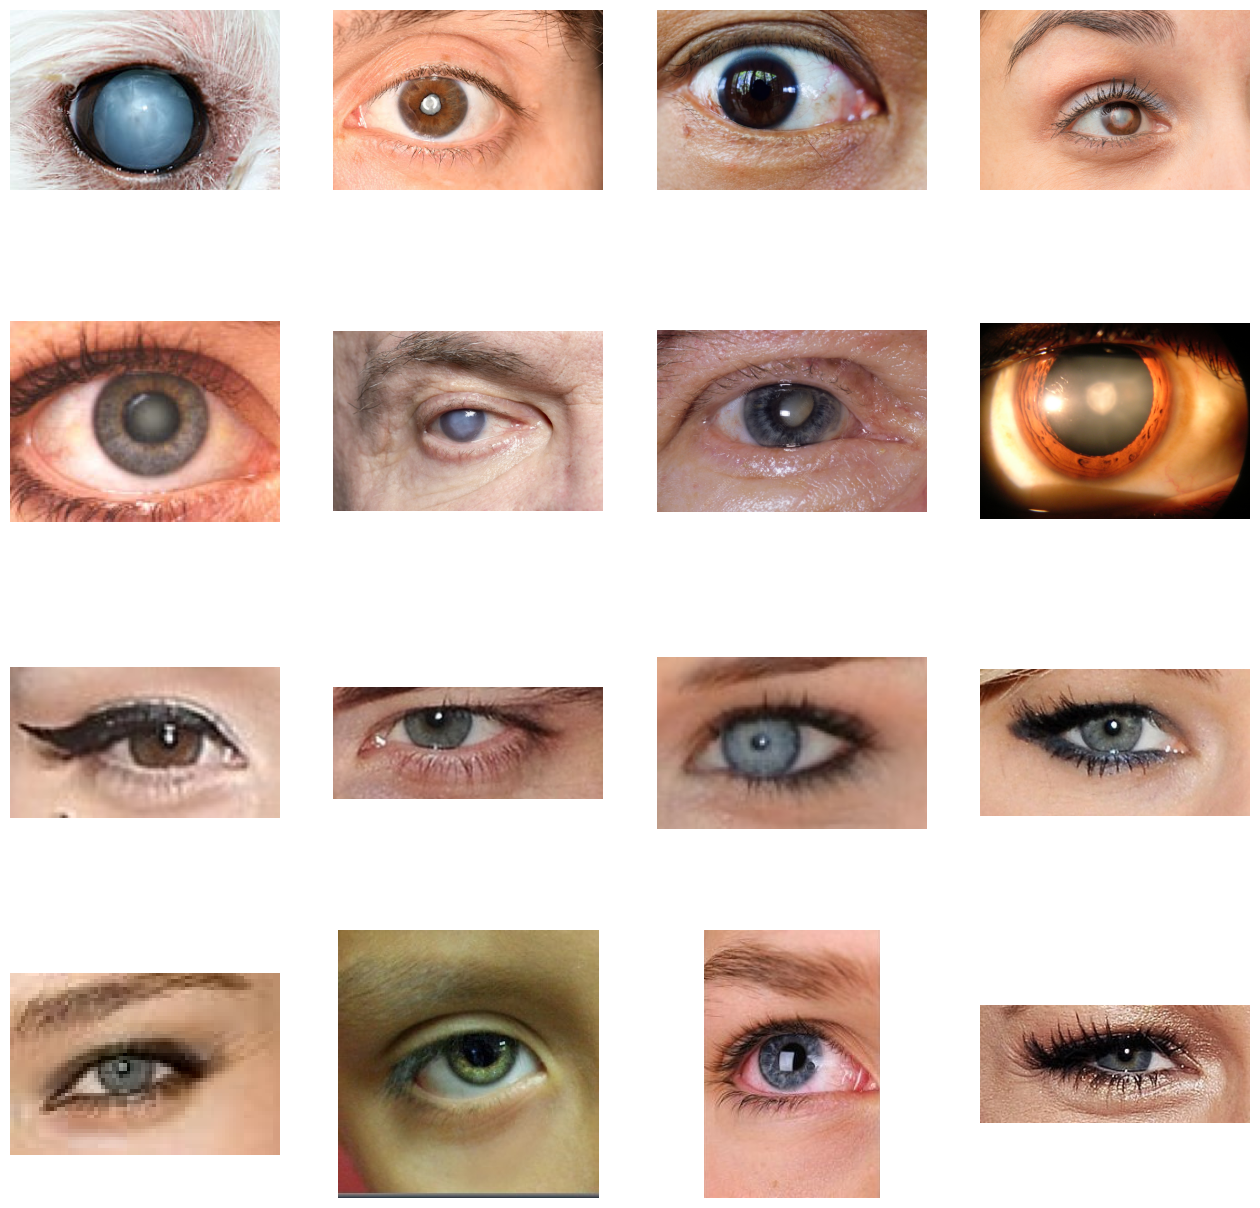

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/cataract")
train_nonsensitive_dir = os.path.join(training_folder+"/normal")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname)
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname)
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Model

In [ ]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.98

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
  # 2D Convolution Layer - Filter, Kernel_size, activation fn
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  # Max pooling operation for 2D data - Pool size
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flattens the input. Does not affect the batch size.
  tf.keras.layers.Flatten(),
  # Regular densely-connected Neural Network layer with ReLU activation function.
  tf.keras.layers.Dense(512, activation='relu'),
  # Regular densely-connected Neural Network layer with sigmoid activation function.
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## Preprocessing, Data Augmentation & Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary',
        shuffle=True
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=True
        )

num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=num_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Epoch 1/500
10/10 [==============================] - 50s 4s/step - loss: 0.7123 - accuracy: 0.5302 - val_loss: 0.6894 - val_accuracy: 0.5250
Epoch 2/500
10/10 [==============================] - 29s 3s/step - loss: 0.6896 - accuracy: 0.5801 - val_loss: 0.6785 - val_accuracy: 0.8250
Epoch 3/500
10/10 [==============================] - 19s 2s/step - loss: 0.6683 - accuracy: 0.6014 - val_loss: 0.5883 - val_accuracy: 0.7000
Epoch 4/500
10/10 [==============================] - 19s 2s/step - loss: 0.6360 - accuracy: 0.6733 - val_loss: 0.4689 - val_accuracy: 0.8750
Epoch 5/500
10/10 [==============================] - 16s 2s/step - loss: 0.5853 - accuracy: 0.7300 - val_loss: 0.4636 - val_accuracy: 0.7500
Epoch 6/500
10/10 [==============================] - 14s 1s/step - loss: 0.4783 - accuracy: 0.7933 - val_loss: 0.3756 - val_accuracy: 0.8750
Epoch 7/500
10/10 [==============================] - 17s 2s/step - loss:

## Plotting Accuracy and Loss Functions

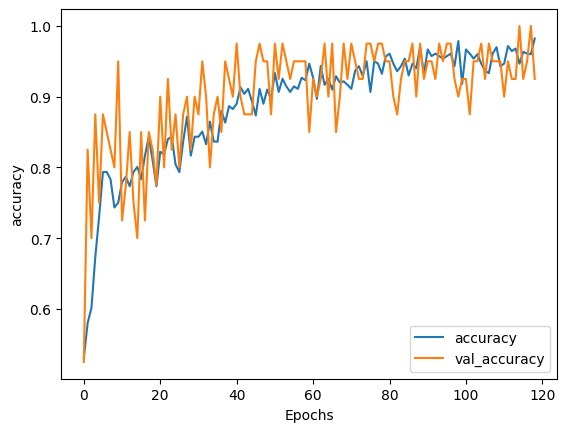

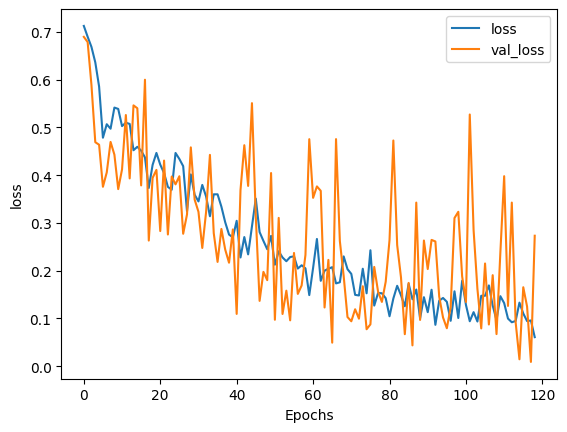

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Saving the model

In [ ]:
# Save and convert the model (Used for deploying in web application)
model.save('model/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved the model successfully
Selecting previously unselected package python3-distlib.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../00-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../01-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-setuptools.
Preparing to unpack .../02-python3-setuptools_59.6.0-1.2ubuntu0.22.04.1_all.deb ...
Unpacking python3-setuptools (59.6.0-1.2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../03-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../04-python3-pip_22.0.2+dfsg-1ubuntu0.3_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.3) ...
Select

## Sample Example

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - normal")
    result[fn] = "normal"
  else:
    print(fn + " - cataract")
    result[fn] = "cataract"

plt.figure(figsize=(20,20))

for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)

TypeError: ignored